In [77]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

### Unstructured Variance, n_input = 15, n_output = 1 

In [4]:
df = pd.read_excel("Data/US15I1O.xlsx", index_col = 0)
df

,Input 1,Input 2,Input 3,Input 4,Input 5,Input 6,Input 7,Input 8,Input 9,Input 10,Input 11,Input 12,Input 13,Input 14,Input 15,Output 1
DMU 1,275.46,50.34,340.07,198.33,252.31,152.33,171.94,351.93,99.92,276.03,521.97,377.73,182.73,323.82,149.79,604.61
DMU 2,215.47,60.38,340.06,310.86,293.92,194.99,213.47,449.00,236.11,219.68,448.57,389.20,136.40,381.47,155.19,549.84
DMU 3,300.23,64.11,340.12,309.33,318.17,150.53,158.62,260.07,220.55,198.77,347.80,180.49,143.57,314.84,152.35,374.89
DMU 4,318.80,70.69,340.03,308.70,284.31,177.03,184.56,248.79,196.65,194.76,308.82,370.43,154.72,236.00,150.82,308.83
DMU 5,308.48,76.50,340.03,300.18,320.88,186.92,207.32,311.17,217.06,213.73,369.79,371.99,140.98,334.56,153.16,478.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 996,229.84,62.77,340.10,307.80,251.16,170.90,181.09,345.93,209.08,206.03,420.21,324.91,145.44,267.75,152.00,434.69
DMU 997,277.75,63.85,340.07,297.61,292.52,163.04,211.13,295.84,217.56,231.60,454.72,233.57,140.77,400.10,155.33,528.69
DMU 998,245.12,44.22,340.05,310.36,284.72,157.20,154.61,341.60,168.51,281.86,383.23,351.73,166.37,259.97,151.17,448.42
DMU 999,229.51,72.14,340.09,313.09,277.03,161.84,177.60,347.74,232.43,226.38,397.84,333.21,132.83,351.30,154.23,483.78


In [5]:
df_sol = pd.read_excel("Data/US15I1O_Solution.xlsx", index_col = 0, header=1)
df_sol

,Efficiency
DMU,
DMU 1,1.000000
DMU 2,0.812848
DMU 3,0.807381
DMU 4,0.601498
DMU 5,0.783913
...,...
DMU 996,0.729545
DMU 997,0.944673
DMU 998,0.783763


In [6]:
import mitosheet
mitosheet.sheet(df_sol, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-e813f772-12aa-43e3-a960-e89d8d12eeae", "code": {"imports…

In [ ]:
df_weights = pd.read_excel("Data/US15I1O_Solution.xlsx", index_col = 0, header=1, sheet_name="InputOutputWeights")
df_weights

In [86]:
import mitosheet
mitosheet.sheet(df_weights, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-1efe264b-2dc6-435b-a0b4-227acfcdeb7c", "code": {"imports…

In [85]:
(df_weights==0).sum()

Efficiency      0
Input 6       833
Input 7       898
Input 3       998
Input 14      351
Input 15      990
Input 2       746
Input 13      881
Input 4       881
Input 10      570
Input 9       818
Input 8       447
Input 1       781
Input 12      298
Input 5       844
Input 11      384
Output 1        0
dtype: int64

### ML

In [9]:
X = df
X.head()

,Input 1,Input 2,Input 3,Input 4,Input 5,Input 6,Input 7,Input 8,Input 9,Input 10,Input 11,Input 12,Input 13,Input 14,Input 15,Output 1
DMU 1,275.46,50.34,340.07,198.33,252.31,152.33,171.94,351.93,99.92,276.03,521.97,377.73,182.73,323.82,149.79,604.61
DMU 2,215.47,60.38,340.06,310.86,293.92,194.99,213.47,449.00,236.11,219.68,448.57,389.20,136.40,381.47,155.19,549.84
DMU 3,300.23,64.11,340.12,309.33,318.17,150.53,158.62,260.07,220.55,198.77,347.80,180.49,143.57,314.84,152.35,374.89
DMU 4,318.80,70.69,340.03,308.70,284.31,177.03,184.56,248.79,196.65,194.76,308.82,370.43,154.72,236.00,150.82,308.83
DMU 5,308.48,76.50,340.03,300.18,320.88,186.92,207.32,311.17,217.06,213.73,369.79,371.99,140.98,334.56,153.16,478.87


In [10]:
y = df_sol
y.head()

,Efficiency
DMU,
DMU 1,1.000000
DMU 2,0.812848
DMU 3,0.807381
DMU 4,0.601498
DMU 5,0.783913


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [12]:
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.003879776567786912
neg_root_mean_squared_error: -0.06216058880123937
r2: 0.7249161277287101


In [13]:
# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

In [14]:
grid = GridSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                         'decisiontreeregressor__max_features': ['auto', 'log2',
                                                                 'sqrt', None],
                         'decisiontreeregressor__min_samples_split': [10, 20,
                                                                      30, 40,
                                                                      50]},
             scoring='neg_root_mean_squared_error')

In [15]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

-0.05569275381498059
{'decisiontreeregressor__max_depth': 11, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 20}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, max_features='auto',
                                       min_samples_split=20,
                                       random_state=42))])
r2: 0.777468548256491


In [16]:
imp_dt = grid.best_estimator_.steps[1][1].feature_importances_
imp_dt

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.01, 0.01, 0.03, 0.05, 0.  , 0.08, 0.  , 0.77])

In [17]:
#pipe_dt.fit(X, y)
#
#imp_dt = pipe_dt.steps[1][1].feature_importances_
#imp_dt

In [18]:
df_dt = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_dt}).sort_values("Importance", ascending=False)
df_dt

,Feature Name,Importance
15,Output 1,0.772638
13,Input 14,0.083256
11,Input 12,0.045409
10,Input 11,0.033443
7,Input 8,0.031738
...,...,...
0,Input 1,0.001681
3,Input 4,0.001567
5,Input 6,0.001298
12,Input 13,0.000812


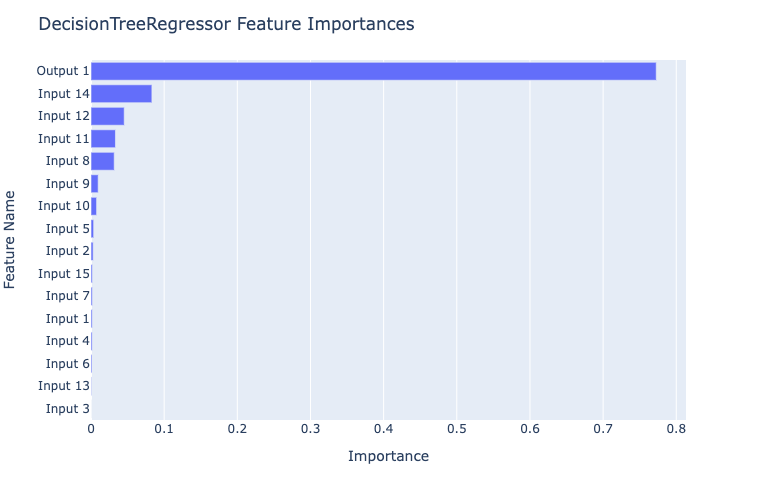

In [19]:
fig = px.bar(df_dt, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [20]:
rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)


# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0017861698126696239
neg_root_mean_squared_error: -0.042087615550590124
r2: 0.8732397654825557


In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
print(n_estimators)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
print(max_depth)
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [22]:
# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

In [23]:
grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                

In [24]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.042942477891797594
{'randomforestregressor__n_estimators': 2000, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 60, 'randomforestregressor__bootstrap': True}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=60, min_samples_leaf=4,
                                       min_samples_split=5, n_estimators=2000,
                                       random_state=42))])
r2: 0.8677725308029529


In [25]:
imp_rf = grid.best_estimator_.steps[1][1].feature_importances_
imp_rf

array([0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.03, 0.01, 0.01, 0.05, 0.03, 0.  , 0.08, 0.  , 0.76])

In [26]:
#pipe_rf.fit(X, y.values.ravel())
#
#imp_rf = pipe_rf.steps[1][1].feature_importances_

In [27]:
df_rf = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_rf}).sort_values("Importance", ascending=False)
df_rf

,Feature Name,Importance
15,Output 1,0.758952
13,Input 14,0.078416
10,Input 11,0.045150
11,Input 12,0.033504
7,Input 8,0.031238
...,...,...
5,Input 6,0.003853
0,Input 1,0.003729
14,Input 15,0.003643
6,Input 7,0.003596


In [28]:
fig = px.bar(df_rf, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [56]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0012614497139167755
neg_root_mean_squared_error: -0.03537182973992726
r2: 0.910204375410548


In [57]:
#learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
#n_estimators = [200, 500, 1000, 2000]
#max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#print(max_depth)
#max_depth.append(None)
## Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
## Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

In [58]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [59]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [60]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error",random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [61]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.026471280994980535
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=2,
                                           min_samples_split=30,
                                           n_estimators=500, random_state=42,
                                           subsample=0.3))])
r2: 0.9492713661330653


In [62]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.04, 0.02, 0.03, 0.05, 0.06, 0.01, 0.1 , 0.01, 0.62])

In [63]:
#pip_gb.fit(X, y.values.ravel())
#
#imp_gb = pip_gb.steps[1][1].feature_importances_

In [64]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
15,Output 1,0.620830
13,Input 14,0.102176
11,Input 12,0.060905
10,Input 11,0.054743
7,Input 8,0.041807
...,...,...
14,Input 15,0.007803
12,Input 13,0.006719
5,Input 6,0.006497
6,Input 7,0.006016


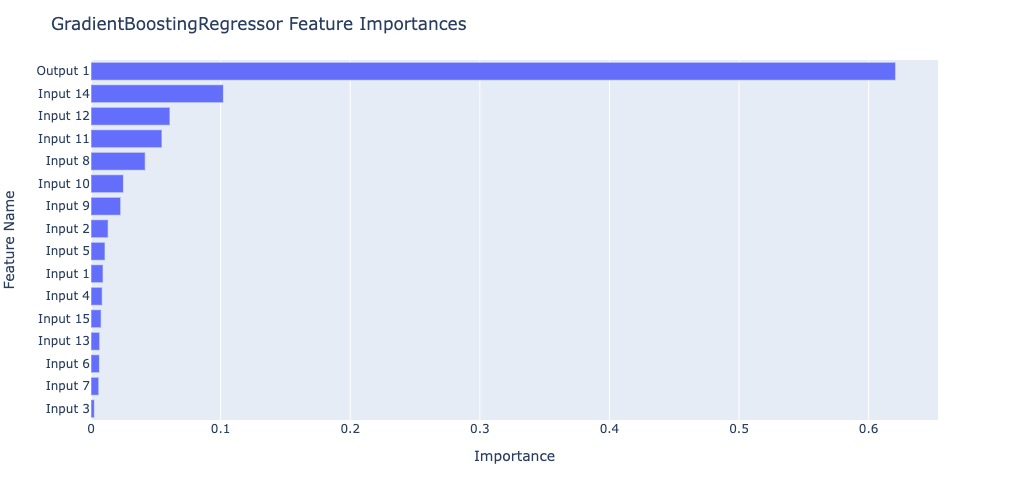

In [65]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [70]:
model = grid.best_estimator_.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)

In [74]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res.index = X_test.index
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
DMU 522,0.6307,0.6447,-0.0140,-2.1717,True
DMU 738,0.9327,0.9493,-0.0166,-1.7467,True
DMU 741,0.8313,0.8301,0.0012,0.1488,True
DMU 661,0.9718,1.0000,-0.0282,-2.8184,True
DMU 412,0.9040,1.0000,-0.0960,-9.5983,False
...,...,...,...,...,...
DMU 409,0.8926,0.9051,-0.0125,-1.3855,True
DMU 333,0.8402,0.8685,-0.0283,-3.2614,False
DMU 209,0.5884,0.6201,-0.0317,-5.1144,False
DMU 614,0.9116,1.0000,-0.0884,-8.8379,False


In [75]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

156


44

In [78]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9835
p-Value 0.0


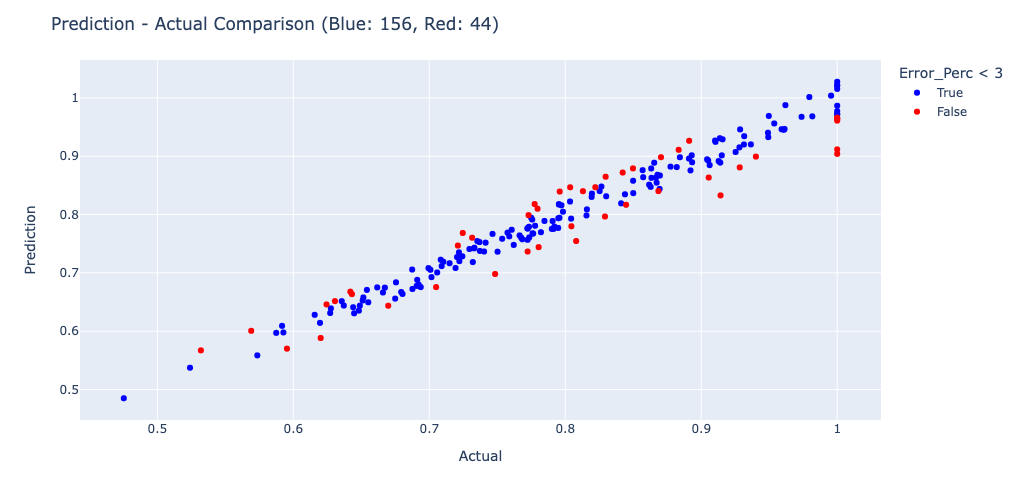

In [83]:
fig = px.scatter(res.reset_index().rename(columns={'index': 'DMU'}), x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc", "DMU"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [39]:
xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0014252435960046112
neg_root_mean_squared_error: -0.03747206183204708
r2: 0.8982668811812815


In [40]:
# xgb.plot_tree(xgb_model,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

In [41]:
learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

In [42]:
# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

In [43]:
grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           enable_categorical=False,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type=None,
                                                           interaction_constrai

In [44]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.03475947493819193
{'xgbregressor__subsample': 0.8999999999999999, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__colsample_bytree': 0.4, 'xgbregressor__colsample_bylevel': 0.8999999999999999}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.8999999999999999,
                              colsample_bynode=1, colsample_bytree=0.4,
                              enable_categorical=False, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.3, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor=

In [45]:
imp_xgb = grid.best_estimator_.steps[1][1].feature_importances_
imp_xgb

array([0.02, 0.04, 0.03, 0.03, 0.05, 0.01, 0.02, 0.09, 0.06, 0.07, 0.06, 0.06, 0.03, 0.09, 0.03, 0.3 ], dtype=float32)

In [46]:
df_xgb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_xgb}).sort_values("Importance", ascending=False)
df_xgb

,Feature Name,Importance
15,Output 1,0.295768
7,Input 8,0.087086
13,Input 14,0.086274
9,Input 10,0.067548
11,Input 12,0.062744
...,...,...
12,Input 13,0.030856
2,Input 3,0.026930
6,Input 7,0.022426
0,Input 1,0.020615


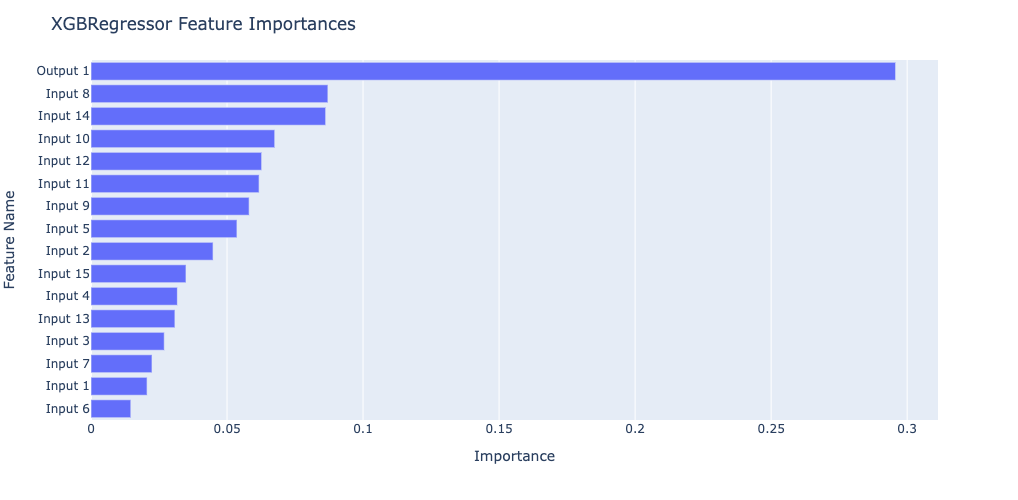

In [47]:
fig = px.bar(df_xgb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [48]:
pipe_xgb.fit(X, y.values.ravel())

pipe_xgb.steps[1][1].feature_importances_

array([0.  , 0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.04, 0.01, 0.01, 0.07, 0.03, 0.  , 0.08, 0.  , 0.71], dtype=float32)

In [49]:
pipe_xgb.steps[1][1].get_booster().get_score(importance_type='cover')

{'f0': 94.32086944580078,
 'f1': 152.55462646484375,
 'f2': 94.84127044677734,
 'f3': 150.28773498535156,
 'f4': 115.40243530273438,
 'f5': 186.92990112304688,
 'f6': 159.74073791503906,
 'f7': 201.76441955566406,
 'f8': 186.95706176757812,
 'f9': 231.85464477539062,
 'f10': 184.44737243652344,
 'f11': 231.9663848876953,
 'f12': 180.46617126464844,
 'f13': 177.57339477539062,
 'f14': 151.96324157714844,
 'f15': 295.7054748535156}

In [50]:
plt.rcParams['figure.figsize'] = [12, 10]

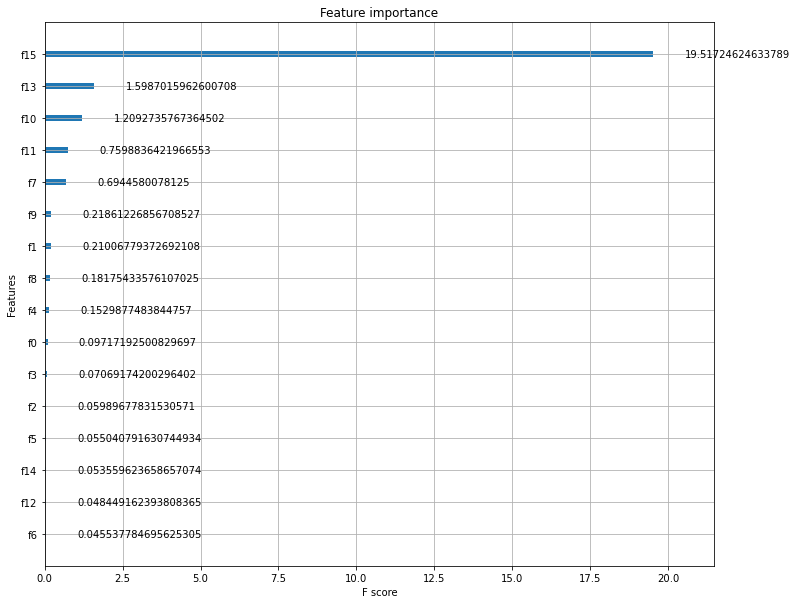

In [51]:
xgb.plot_importance(pipe_xgb.steps[1][1]._Booster, importance_type='total_gain')
plt.show()